<h1>Gamma Delta T-cells</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
if os.path.isfile('algo_times.csv'):
    performance = pd.read_csv('algo_times.csv').to_dict('list')
else:
    performance = dict(sample_id=[], task=[], method=[], time_seconds=[])

In [4]:
def timed_apply(sample_go, task_name, gate_name, performance_record, plot=True, save=True):
    start = datetime.now()
    sample_go.apply(gate_name, plot_output=plot)
    end = datetime.now()
    performance['sample_id'].append(sample_go.id)
    performance['method'].append(gate_name)
    performance['time_seconds'].append((end-start).total_seconds())
    performance['task'].append(task_name)
    if save:
        pd.DataFrame(performance).to_csv('algo_times.csv', index=False)
    return performance_record

In [5]:
def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [6]:
def visualise_manual_ellipse(sample_go, population, x, y, centroid, width, height, angle, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(population)[[x, y]], features_to_transform=[x,y],
                           transform_method='logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [7]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

Remove autonomous gates and populations applied with erronous gates.

In [8]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [11]:
populations_to_remove = ['gmm_gdt', 'gmm_gdtNEG', 'dbscan_gdt', 'dbscan_nongdt', 'dbscan_vd2',
                        'hdbscan_gdt', 'hdbscan_nongdt', 'hdbscan_vd2', 'dens2d_gdt', 'dens2d_nongdt',
                        'dens2d_vd2', 'dens2d_noise']
gates_to_remove = ['gmm_gdt', 'dbscan_gdt', 'hdbscan_gdt', 'dens2d_gdt']
for x in samples:
    hc = Gating(exp, x)
    for p in populations_to_remove:
        if p in hc.populations.keys():
            hc.populations.pop(p)
    for g in gates_to_remove:
        if g in hc.gates.keys():
            hc.gates.pop(g)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [9]:
for x in samples:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    
    print('mixture model...')
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_gdt', definition='+')
    child_populations.add_population('gmm_gdtNEG', definition='-')

    pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

    sampling_kwargs = dict()
    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('hdbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                              performance_record=performance, save=True, plot=False)
    
    print('2D density threshold...')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition=['++'])
    child_populations.add_population('dens2d_nongdt', definition=['--'])
    child_populations.add_population('dens2d_vd2', definition=['-+'])
    child_populations.add_population('dens2d_noise', definition=['+-'])
    gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=True, plot=False)
    hc.save(overwrite=True)
    print('Complete!')
    print('.........................................................')

Gating hc1...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
hdbscan...
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc4...
mixture model...
dbscan...
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
hdbscan...
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc5...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_gdt', 'dbscan_vd2'] assigned to the same cluster 1;prioritising dbscan_gdt based on weighting.
hdbscan...
Populations f['hdbscan_gdt', 'hdbscan_vd2'] assigned to the same cluster 0;prioritising hdbscan_gdt based on weighting.
2D density threshold...
Saved successfu

<h2>Evaluate performance</h2>

In [48]:
from tqdm import tqdm, tqdm_notebook
def calc_performance(so, true_pop_name, predicted_pop_name, parent):
    parent = so.get_population_df(parent)
    automated = so.get_population_df(predicted_pop_name)
    manual = so.get_population_df(true_pop_name)
    parent['auto'], parent['manual'] = 0, 0
    parent['auto'] = parent['auto'].mask(parent.index.isin(automated.index), 1)
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual.index), 1)
    
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    fpr = fp/(fp+tn)
    
    return dict(recall=recall, precision=precision, accuracy=accuracy, f1_score=f1, FPR=fpr)

gdt_performance = list()
nongdt_performance = list()
vd2_performance = list()
for x in tqdm(samples):
    hc = Gating(exp, x)
    #GMM
    results = calc_performance(hc, 'manual_gdt', 'gmm_gdt', 'manual_liveCD3')
    results['method'] = 'gmm'
    results['id'] = x
    gdt_performance.append(results)
    #DBSCAN
    results = calc_performance(hc, 'manual_gdt', 'dbscan_gdt', 'manual_liveCD3')
    results['method'] = 'dbscan'
    results['id'] = x
    gdt_performance.append(results)
    results = calc_performance(hc, 'manual_nongdt', 'dbscan_nongdt', 'manual_liveCD3')
    results['method'] = 'dbscan'
    results['id'] = x
    nongdt_performance.append(results)
    results = calc_performance(hc, 'manual_vd2Neg', 'dbscan_vd2', 'manual_liveCD3')
    results['method'] = 'dbscan'
    results['id'] = x
    vd2_performance.append(results)
    #HDBSCAN
    results = calc_performance(hc, 'manual_gdt', 'hdbscan_gdt', 'manual_liveCD3')
    results['method'] = 'hdbscan'
    results['id'] = x
    gdt_performance.append(results)
    results = calc_performance(hc, 'manual_nongdt', 'hdbscan_nongdt', 'manual_liveCD3')
    results['method'] = 'hdbscan'
    results['id'] = x
    nongdt_performance.append(results)
    results = calc_performance(hc, 'manual_vd2Neg', 'hdbscan_vd2', 'manual_liveCD3')
    results['method'] = 'hdbscan'
    results['id'] = x
    vd2_performance.append(results)
    #2D Density Threshold
    results = calc_performance(hc, 'manual_gdt', 'dens2d_gdt', 'manual_liveCD3')
    results['method'] = 'dens2d'
    results['id'] = x
    gdt_performance.append(results)
    results = calc_performance(hc, 'manual_nongdt', 'dens2d_nongdt', 'manual_liveCD3')
    results['method'] = 'dens2d'
    results['id'] = x
    nongdt_performance.append(results)
    results = calc_performance(hc, 'manual_vd2Neg', 'dens2d_vd2', 'manual_liveCD3')
    results['method'] = 'dens2d'
    results['id'] = x
    vd2_performance.append(results)
    

100%|██████████| 14/14 [01:18<00:00,  5.63s/it]


In [61]:
gdt_results = pd.DataFrame(gdt_performance)
nongdt_results = pd.DataFrame(nongdt_performance)
vd2_results = pd.DataFrame(vd2_performance)

In [62]:
import seaborn as sns

In [63]:
def rename_method(x):
    if 'gmm' in x:
        return 'Gaussian Mixture Model'
    if 'hdbscan' in x:
        return 'HDBSCAN'
    if 'dbscan' in x:
        return 'DBSCAN'
    if 'dens2d' in x:
        return 'Density threshold (2D)'
    return x
gdt_results['method'] = gdt_results['method'].apply(rename_method)
nongdt_results['method'] = nongdt_results['method'].apply(rename_method)
vd2_results['method'] = vd2_results['method'].apply(rename_method)

Text(0, 0.5, '')

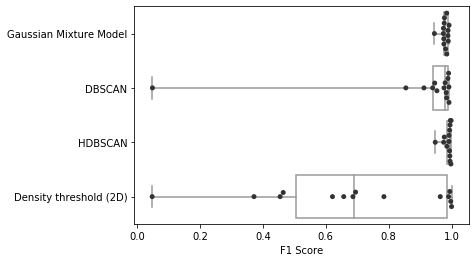

In [64]:
ax = sns.boxplot(x="f1_score", y="method", data=gdt_results, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=gdt_results, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

Text(0, 0.5, '')

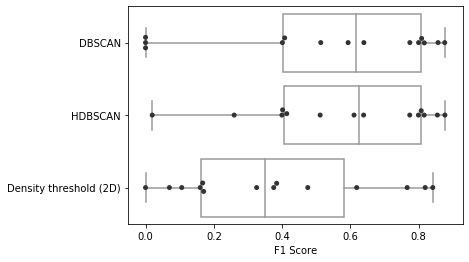

In [65]:
ax = sns.boxplot(x="f1_score", y="method", data=nongdt_results, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=nongdt_results, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

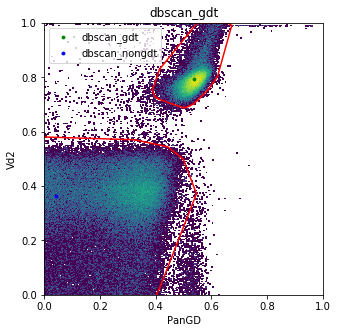

In [78]:
hc = Gating(exp, 'hc4')
hc.plotting.plot_gate('dbscan_gdt')

In [79]:
hc.populations['dbscan_gdt']

Node('/root/cells/lymphocytes/manual_liveCD3/dbscan_gdt', geom={'shape': 'cluster', 'x': 'PanGD', 'y': 'Vd2'}, index=array([     4,     15,     21, ..., 627738, 627739, 627747]), prop_of_parent=0.1987702539381235, prop_of_total=0.09274581519972983, warnings=["Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting."])

In [83]:
data = apply_transform(hc.get_population_df('dbscan_nongdt'), ['PanGD', 'Vd2'], 'logicle')
parent = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [96]:
import math
d = np.ceil(parent.shape[0]/30000)
chunksize = np.ceil(parent.shape[0]/d)
int(chunksize)

29291

Text(0, 0.5, '')

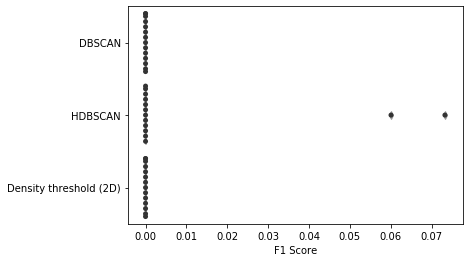

In [66]:
ax = sns.boxplot(x="f1_score", y="method", data=vd2_results, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=vd2_results, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')